In [5]:
%%HTML
<link rel="stylesheet" type="text/css" href="../custom.css">

# 応用計量分析２（第10回）
混合分布モデルとEMアルゴリズム






### 担当教員: 梶野 洸（かじの ひろし）


# 概要
混合分布モデル

- 混合分布モデルの導入（混合ガウスモデル）
- EM アルゴリズムの導出

# 混合分布モデル
複数の分布を混合したモデル

$$
p(x) = \sum_{z\in\mathcal{Z}}p(x \mid z) p(z)
$$

- $p(x \mid z)$: 複数の分布（$z\in\mathcal{Z}$ごとに異なる分布）
- $p(z)$: 混合割合
- $p(x)$: 最終的に得られる分布

# 例: 混合ガウスモデル
有限個のガウス分布を混合したモデル

$$
p(x) = \sum_{k=1}^{K} p(x \mid z=k) p(z=k)
$$
where
$$
\begin{align}
p(x \mid z=k) &= \mathcal{N}(x; \mu_{k}, \Sigma_{k})~(\mu_k\in\mathbb{R}^D, \Sigma_{k}\in\mathbb{S}_{+}^D)\\
p(z=k) &= \pi_k~(k=1,\dots,K)
\end{align}
$$
ここで $\sum_{k=1}^K \pi_k = 1$ が成り立つとする。

# 例: 混合ガウスモデル
有限個のガウス分布を混合したモデル

$$
p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x; \mu_{k}, \Sigma_{k})
$$

と書くことが多い。

# 例: 混合ガウスモデル

混合ガウスモデルは $K+1$ 個の確率分布で構成される

- $\mathrm{Categorical}(\mathbf{\pi})$, $\pi\in\Delta^K$
    - カテゴリカル分布（$K$面サイコロ）
    - 各面 $k$ が出る確率が $\pi_{k}$
- $\mathcal{N}(\mu_k,\Sigma_k)$ ($k=1,\dots,K$): $K$個の異なる正規分布
    - 平均 $\mu_k$, 分散共分散行列 $\Sigma_k$

# 例: 混合ガウスモデル
2つの正規分布からなる GMM

<img src="figs/gmm_example.png" width="1024px">

# 生成モデルとしての説明
確率変数 $X$ を生成する過程としても解釈できる

- $K$ 面サイコロで $k$ の目が出る確率: $p(z=k)$
- $k$ の目が出た条件のもとで確率変数 $X$ が従う確率分布: $p(x \mid z=k)$
- $(Z, X)=(z,x)$ となる確率: $p(x, z) = p(x \mid z) p(z)$
- $X$ の従う確率分布だけ見ると $p(x) = \sum_{k=1}^K p(x \mid z=k) p(z=k)$

<img src="figs/gmm.png" width="1024px">

# 生成モデルとしての説明
数式では以下のように書く

$$
\begin{align}
Z &\sim \mathrm{Categorical}(\mathbf{\pi})\\
X &\sim \mathcal{N}(\pi_{Z}, \Sigma_{Z})
\end{align}
$$

- 一行目で$K$面サイコロを振って $Z$ の実現値（$k$とする）を得る
- 二行目で $Z=k$ に対応する正規分布から $X$ の実現値を得る

# 混合モデルを考える理由

- 既知の確率分布を組み合わせて複雑な確率分布を表現できる
    - 正規分布単体では単峰の分布しか表現できない
    - 正規分布を重ね合わせると複数の山を表現できる

- 潜在変数$Z$からの知識発見
    - 事後分布 $p(z \mid X=x)$ は、データ $x$ がどの分布から出てきたのかを表す
    - クラスタリングのような効果

<font color="Red">★</font>のデータ $X$ は $Z=1$ から生成されたっぽい
<img src="figs/gmm_posterior.png" width="1024px">

# ここまでのまとめ

- 混合分布モデルを使うと複雑な確率分布も表現できる
- 正規分布を有限個混合したモデルとして、混合ガウスモデルがある
- データが生成される過程として書くことができる
- クラスタリングのような使い方ができる

# 演習

次のGMMに従う確率変数 $X$ を生成し、ヒストグラムを書け

混合数$K=2$, 次元$D=1$

$p(z=0)=p(z=1)=1/2$

$p(x\mid z=0) = \mathcal{N}(x; -5, 1)$

$p(x\mid z=1) = \mathcal{N}(x; 5, 1)$

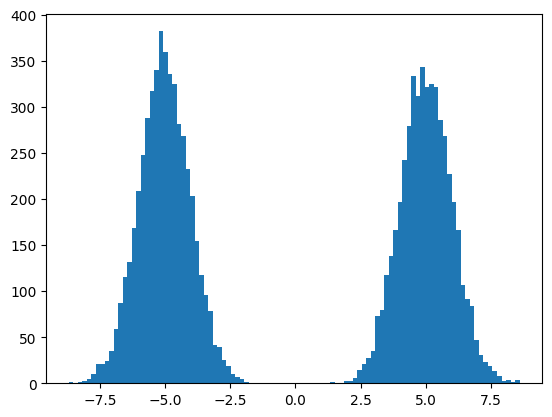

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def gmm_sampling(sample_size):
    z_sample = np.random.binomial(n=1, p=0.5, size=(sample_size,))
    x_sample = np.random.randn(sample_size)
    return x_sample + 10.0 * z_sample - 5.0

sample = gmm_sampling(10000)
plt.hist(sample, bins=100)
plt.show()

# 混合ガウスモデルの推定

- ここまでは確率モデルが与えられたときにそれをどう解釈するかを議論していた
- データセット $\mathcal{D} = \{x_1,\dots,x_N\}$ が与えられた時、そのデータセットが従う GMM を推定するにはどうしたら良いか？


# 混合ガウスモデルの自由度

- $K$個の正規分布の平均ベクトル、共分散行列
- どの正規分布を選ぶか決める確率分布 $\pi_k=p(z=k)$ ($k=1,\dots,K$)
- 混合数$K$

# 最尤推定で求まるもの
混合数は求まらない

- $K$個の正規分布の平均ベクトル、共分散行列
- どの正規分布を選ぶか決める確率分布 $\pi_k=p(z=k)$ ($k=1,\dots,K$)

# 最尤推定

$$
\theta^\star = \arg\max_{\theta\in\Theta}p(\mathcal{D} ; \theta)
$$
をパラメタの推定値とする

各データの独立同分布性を仮定すると

$$
\begin{align}
\log p(\mathcal{D}; \theta) &= \sum_{n=1}^N \log p(x_n; \theta)\\
\end{align}
$$

モデルの仮定では、 $p(x;\theta) = \sum_{z=1}^{K}p(x \mid z;\theta)p(z;\theta)$ だったので、上式は、

$$
\begin{align}
\sum_{n=1}^N \log \left( \sum_{z_n=1}^{K} p(x_n \mid z_n; \theta)p(z_n;\theta)\right)\tag{1}
\end{align}
$$

となる。

最尤推定量は式(1)を最大化することで求まる。

最大化の手法は二種類

1. 勾配法で式(1)を直接最大化する
1. EMアルゴリズムで最大化する（今回はこっち！）

# Expectation-maximization (EM) アルゴリズム
隠れ変数があるモデルの最尤推定量を求めるアルゴリズム

- 現状は各データの隠れ変数 $z_n$ もパラメタ $\theta$ もわからない
    1. $z_n$ が1つに決まれば $\theta$ がわかる
    1. $\theta$ が1つに決まれば $z_n$ がわかる

- とりあえずどちらかを初期化して、1, 2 を繰り返せばいい感じの $z_n$, $\theta$ が求まりそう
    - 局所最適解が求まることが示せる
    - （大域的最適解を求めるのはそもそも難しいので諦めている）

# EM アルゴリズムの利点

- EステップとMステップが解析的に書ける
    - 毎ステップで尤度が下がらないことが保証される
    - 勾配法だと、ステップサイズによって尤度が下がることもある
- より難しいモデルの推定にも同じようなアイデアが適用できる

# 演習

1. $X_n$ の実現値だけでなく $Z_n$ の実現値も得られていた場合の最尤推定量 $\theta^\star$ を計算せよ
    - $(x_n, z_n)$ が $p(x, z;\theta)= \pi_{z}\mathcal{N}(x; \mu_z, \Sigma_z)$ という同時分布に従っている
    - $-\sum_{n=1}^{N}\log p(x_n, z_n;\theta)$ を $\theta$ について最小化する
1. $X_n$ の実現値だけでなく、パラメタ$\theta^\star$の値もわかっている場合の隠れ変数の事後分布を計算せよ
    - $p(z_n \mid x_n; \theta^\star)$ を計算する

# 答え

1. $\{(x_n, z_n)\}_{n=1}^N$ が得られていた場合、$x_n, z_n$ の同時分布は、

$$
p(x_n, z_n; \theta) = \pi_{z_n} \mathcal{N}(x_n; \mu_{z_n}, \Sigma_{z_n})
$$


$$
\begin{align}
&-\sum_{n=1}^{N}\log p(x_n, z_n;\theta) \\
=& -\sum_{n=1}^N  \sum_{k=1}^K \mathbb{1}[z_n=k]\left(\log\pi_{k} + \log\mathcal{N}(x_n; \mu_{k}, \Sigma_{k})\right)\\
=&\sum_{n=1}^N \sum_{k=1}^K \mathbb{1}[z_n=k]\left(-\log\pi_{k} + \dfrac{1}{2}(x_n - \mu_{k})^\top \Sigma_{k}^{-1} (x_n - \mu_{k})\right.\\
&\hspace{5cm} \left.+ \dfrac{D}{2}\log 2\pi + \dfrac{1}{2}\log\det\Sigma_{k}\right)\tag{2}\\
\end{align}
$$

### $\mu_k$ についての最大化

式(2)を$\mu_k$で微分すると
$$
\sum_{n=1}^{N}\mathbb{1}[z_n=k]\Sigma_{k}^{-1}(x_n - \mu_k)
$$
なので、$\mu_k$の最尤推定量は
$$
\mu_k^{\star} = \dfrac{\sum_{n=1}^N \mathbb{1}[z_n=k]x_n}{\sum_{n=1}^N \mathbb{1}[z_n=k]}
$$
となる。

### $\Sigma_k$ についての最大化

式(2)を$\Sigma_k$で微分すると

$$
\dfrac{1}{2}\sum_{n=1}^N \mathbb{1}[z_n=k]\left(-\Sigma_k^{-1}(x_n - \mu_k)(x_n - \mu_k)^\top\Sigma_k^{-1} + \Sigma_k^{-1}\right)
$$

なので、$\Sigma_k$の最尤推定量は

$$
\Sigma_k^\star = \dfrac{\sum_{n=1}^{N}\mathbb{1}[z_n=k](x_n - \mu_k^\star)(x_n-\mu_k^\star)^\top}{\sum_{n=1}^{N}\mathbb{1}[z_n=k]}
$$

となる

### $\pi_k$ についての最大化

$\pi_k$ は $\sum_{k=1}^{K}\pi_k=1$ を満たす必要があるため、
式(2)に$\lambda \left(\sum_{k=1}^K \pi_k - 1\right)$を足したものを$\pi_k$で微分して
$$
\sum_{n=1}^N \mathbb{1}[z_n=k]\left(-\dfrac{1}{\pi_k^\star}\right) + \lambda=0
$$
を解けば良い。
$$
\lambda \pi_k^{\star} = \sum_{n=1}^N \mathbb{1}[z_n=k]
$$
を $k=1,\dots,K$ で足すと
$$
\lambda = N.
$$
よって、
$$
\pi_k^{\star} = \dfrac{\sum_{n=1}^N \mathbb{1}[z_n=k]}{N}
$$

(2) $p(z \mid x; \theta) \propto p(x \mid z; \theta)p(z; \theta)$ なので、

$$
p(z_n \mid x_n;\theta^\star) = \dfrac{\pi_{z_n}^{\star}\mathcal{N}(x_n; \mu_{z_n}^{\star}, \Sigma_{z_n}^{\star})}{\sum_{k=1}^K\pi_{k}^{\star}\mathcal{N}(x_n; \mu_{k}^{\star}, \Sigma_{k}^{\star})}
$$

# 演習まとめ

$z_n$ が1つに決まっていると、
$$
\begin{align}
\sum_{n=1}^N \log \left( \sum_{z_n=1}^{K} p(x_n \mid z_n; \theta)p(z_n;\theta)\right)
\end{align}
$$
の log のなかの足し算がなくなって、
$$
\begin{align}
\sum_{n=1}^N \left(\log p(x_n \mid z_n; \theta) + \log p(z_n;\theta)\right)
\end{align}
$$
の最大化となるため、解析的に解ける。

# EM アルゴリズムの導出

任意の分布 $q(z)$ について
$$
\begin{align}
&\log \left(\sum_{z}p(x\mid z; \theta) p(z;\theta)\right)\\
= &\log \left(\sum_{z}p(x\mid z; \theta) \dfrac{p(z;\theta)}{q(z)}q(z)\right)\\
\geq & \sum_{z}q(z)\log \left(p(x\mid z; \theta) \dfrac{p(z;\theta)}{q(z)}\right)\\
= &\sum_{z}q(z)\left(\log p(x, z; \theta) - \log{q(z)}\right)
\end{align}
$$
が成り立つことを利用する。

# 証明（演習）

- $f\colon \mathbb{R}^D \rightarrow \mathbb{R}$: 任意の凸関数
- $x_1,\dots,x_N\in\mathbb{R}^D$ : $f$ の定義域の任意の$N$点
- $w_1,\dots,w_N\in[0,1]$ s.t. $\sum_{n=1}^N w_n = 1$ : 任意の重み

とする。

$$
f\left(\sum_{n=1}^N w_n x_n\right)\leq \sum_{n=1}^N w_n f\left(x_n\right)
$$
を示せ (Jensenの不等式)。

# ヒント
$f: \mathbb{R}^{D}\rightarrow\mathbb{R}$ が凸関数 $\Longleftrightarrow$ 任意の$x_1, x_2\in\mathbb{R}^D$, $w_1, w_2\in[0,1]$ s.t. $w_1 + w_2=1$ について
$$
f(w_1 x_1 + w_2 x_2) \leq w_1 f(x_1) + w_2 f(x_2)
$$

$N$ の時に成り立っているとして、$N+1$の時にも成り立つことを示す。
$$
\begin{align}
& f\left(\sum_{n=1}^{N+1} w_n x_n\right) \\
=& f\left(w_{N+1}x_{N+1} + \sum_{n=1}^N w_n x_n\right)\\
=&f\left(w_{N+1}x_{N+1} + (1-w_{N+1})\sum_{n=1}^N {w_n}\dfrac{x_n}{1-w_{N+1}} \right)\\
\leq & w_{N+1}f(x_{N+1}) + (1-w_{N+1})f\left(\sum_{n=1}^N \dfrac{w_n}{1-w_{N+1}}x_n\right)\\
\end{align}
$$

$$
\begin{align}
\leq & w_{N+1}f(x_{N+1}) + (1-w_{N+1})\sum_{n=1}^N \dfrac{w_n}{1-w_{N+1}}f\left(x_n\right)\ \ \left(\text{note that}\sum_{n=1}^N \dfrac{w_n}{1-w_{N+1}}=1\right)\\
= &\sum_{n=1}^{N+1}w_n f(x_n)
\end{align}
$$

# 再掲

$\log x$ は凹関数なので、任意の分布 $q(z)$ について
$$
\begin{align}
&\log \left(\sum_{z}p(x\mid z; \theta) p(z;\theta)\right)\\
= &\log \left(\sum_{z}p(x\mid z; \theta) \dfrac{p(z;\theta)}{q(z)}q(z)\right)\\
\geq & \sum_{z}q(z)\log \left(p(x\mid z; \theta) \dfrac{p(z;\theta)}{q(z)}\right)\\
= & \sum_{z}q(z)\left(\log p(x, z; \theta) - \log{q(z)}\right) \tag{3}
\end{align}
$$
が成り立つ。

# EMアルゴリズムの導出

尤度（式(3)の左側）を最大化する代わりに尤度の下界（式(3)の右側）を最大化する:
$$
\sum_{n=1}^{N}\sum_{z_n}q(z_n)(\log p(x_n, z_n; \theta) - \log q(z_n))
$$

- $q$ に関する最大化
- $\theta$ に関する最大化

# $q$ を固定して $\theta$ に関して最大化

$$
p(x_n, z_n; \theta) = \pi_{z_n} \mathcal{N}(x_n; \mu_{z_n}, \Sigma_{z_n})
$$


$$
\begin{align}
& -\sum_{n=1}^{N}\sum_{k=1}^K q(z_n=k)\log p(x_n, z_n=k;\theta) \\
=& -\sum_{n=1}^N \sum_{k=1}^K q(z_n=k)\left(\log\pi_{k} + \log\mathcal{N}(x_n; \mu_{k}, \Sigma_{k})\right)\\
=& \sum_{n=1}^N \sum_{k=1}^K q(z_n=k)\left(-\log\pi_{k} + \dfrac{1}{2}(x_n - \mu_{k})^\top \Sigma_{k}^{-1} (x_n - \mu_{k})\right.\\
& \hspace{5cm} \left. + \dfrac{D}{2}\log 2\pi + \dfrac{1}{2}\log\det\Sigma_{k}\right)\\
\end{align}
$$

式(2)で $\mathbb{1}[z_n=k]$ を $q(z_n=k)$ に変えたやつだ！

よって
$$
\begin{align}
\mu_k^{\star} &= \dfrac{\sum_{n=1}^N q(z_n=k)x_n}{\sum_{n=1}^N q(z_n=k)}\\
\Sigma_k^\star &= \dfrac{\sum_{n=1}^{N}q(z_n=k)(x_n - \mu_k^\star)(x_n-\mu_k^\star)^\top}{\sum_{n=1}^{N}q(z_n=k)}\\
\pi_k^{\star} &= \dfrac{\sum_{n=1}^N q(z_n=k)}{N}
\end{align}
$$

# $\theta$ を固定して $q$ に関して最大化

$q$ は $\sum_{k=1}^K q(z_n=k)=1~(n=1,\dots,N)$ を満たす $N\times K$ 個の実数からなる。

$$
\begin{align}
&\dfrac{\partial}{\partial q(z_n=k)}\left(\sum_{n=1}^{N}\sum_{k=1}^K q(z_n=k) \right.\\
& \hspace{3cm} \times (\log p(x_n, z_n=k; \theta) - \log q(z_n=k)) \\
& \hspace{3cm} \left. + \sum_{n=1}^N\lambda_n \left(\sum_{k=1}^K q(z_n=k) - 1\right)\right)\\
=&\log p(x_n, z_n=k;\theta) - \log q(z_n=k) - 1 + \lambda_n = 0
\end{align}
$$
を解くと

$$
\begin{align}
q(z_n=k) &= \dfrac{p(x_n, z_n=k;\theta)}{\sum_{k=1}^K p(x_n, z_n=k;\theta)} \\
&= \dfrac{\pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)}
\end{align}
$$

# EM アルゴリズム

- $\mu_k, \Sigma_k, \pi_k~(k=1,\dots,K)$ を適当に初期化
- 以下を繰り返す:
    - E-step: for each $n=1,\dots,N, k=1,\dots,K$,
    $$q(z_n=k)\leftarrow \dfrac{\pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)}$$
    - M-step: for each $k=1,\dots,K$,
    $$
    \begin{align}
    \mu_k &\leftarrow \dfrac{\sum_{n=1}^N q(z_n=k)x_n}{\sum_{n=1}^N q(z_n=k)}\\
\Sigma_k &\leftarrow \dfrac{\sum_{n=1}^{N}q(z_n=k)(x_n - \mu_k)(x_n-\mu_k)^\top}{\sum_{n=1}^{N}q(z_n=k)}\\
\pi_k &\leftarrow \dfrac{\sum_{n=1}^N q(z_n=k)}{N}
\end{align}
    $$

適当な終了条件で繰り返しをやめる

- 尤度の増分が一定以下になった
- パラメタの変化幅が一定以下になった

# EMアルゴリズムまとめ

- 変分法を用いて尤度の下界を求めた
    - $\sum_{n=1}^{N}\sum_{z_n}q(z_n)\log p(x_n, z_n; \theta)$ みたいな形を出したかった
    - $q$ と $\theta$ を交互に最適化するとそれぞれ解析的に解ける

# EMアルゴリズムの実装


# 演習
混合ガウスモデルの場合、

- 内部状態
- 欲しい命令

は何か？

# 一つの答え

- 内部状態
    - 正規分布の平均、分散共分散行列 $\times K$個
    - 重み $\pi=\begin{bmatrix}\pi_1 &\dots & \pi_K \end{bmatrix}$
- 命令
    - データを入力して、パラメタを最尤推定する
    - データを入力して、各データの潜在変数を推定する（現状の内部状態を使って）

# 他の答え
補助的なものを持っていてもよい

- 内部状態
    - 正規分布の平均、分散共分散行列 $\times K$個
    - 重み $\pi=\begin{bmatrix}\pi_1 &\dots & \pi_K \end{bmatrix}$
    - __混合数 $K$ を陽に持っておくと何かと便利__
- 命令
    - データを入力して、パラメタを最尤推定する
        - __E ステップを実行する__
        - __M ステップを実行する__
        - __尤度を計算する__
    - データを入力して、各データの潜在変数を推定する（現状の内部状態を使って）

# 他の答え2
内部状態として他のクラスのオブジェクトを持っていてもよい

- 正規分布クラス
    - 内部状態
        - 平均
        - 分散共分散行列
    - 命令
        - データを入力して、パラメタを最尤推定する
        - データを入力して、尤度を計算する

- GMM クラス
    - 内部状態
        - 正規分布オブジェクト $\times K$個
        - 重み $\pi=\begin{bmatrix}\pi_1 &\dots & \pi_K \end{bmatrix}$
        - __混合数 $K$ を陽に持っておくと何かと便利__
    - 命令
        - データを入力して、パラメタを最尤推定する
            - __E ステップを実行する__
            - __M ステップを実行する__
            - __尤度を計算する__
        - データを入力して、各データの潜在変数を推定する（現状の内部状態を使って）

# Python での実装

まずは正規分布クラスを実装してみよう

# 課題

正規分布クラスを実装せよ（以前の資料からコピペでOK）

In [ ]:
import numpy as np

class Gaussian:
    def __init__(self, dim):
        '''コンストラクタ（みたいなもの）
        オブジェクトを作るときに初めに実行される。
        内部状態の初期化に使う
        '''
        self.dim = dim
        '''
        self = オブジェクトを指す。 self.dim は、オブジェクトの dim という変数を指す。
        上の命令は、 self.dim に dim の値を代入することを表す
        '''
        self.set_mean(np.random.randn(dim)) # オブジェクトの mean という変数をランダムに初期化
        self.set_cov(np.identity(dim))
        
    def log_pdf(self, X):
        ''' 確率密度関数の対数を返す
        
        Parameters
        ----------
        X : numpy.array, shape (sample_size, dim)
        
        Returns
        -------
        log_pdf : array, shape (sample_size,)
        '''
        if X.shape[1] != self.dim: # 入力の形をチェックしています
            raise ValueError('X.shape must be (sample_size, dim)')
        return -0.5 * np.sum((X - self.mean) * (np.linalg.solve(self.cov, (X - self.mean).T).T), axis=1) \
            -0.5 * self.dim * np.log(2.0 * np.pi) - 0.5 * np.linalg.slogdet(self.cov)[1]

    def fit(self, X):
        ''' X を使って最尤推定をする
                
        Parameters
        ----------
        X : numpy.array, shape (sample_size, dim)
        '''
        if X.shape[1] != self.dim: # 入力の形をチェックしています
            raise ValueError('X.shape must be (sample_size, dim)')
        self.set_mean(np.mean(X, axis=0))
        self.set_cov((X - self.mean).T @ (X - self.mean) / X.shape[0])

    def sample(self, sample_size):
        ''' 現状のパラメタを使って `sample_size` のサイズのサンプルを生成する
        
        Parameters
        ----------------
        sample_size : int
        
        Returns
        -----------
        X : numpy.array, shape (sample_size, dim)
            各行は平均 `self.mean`, 分散 `self.cov` の正規分布に従う
        '''
        return np.random.multivariate_normal(self.mean, self.cov, size=sample_size)
        
    def set_mean(self, mean):
        if mean.shape != (self.dim,):
            raise ValueError('input shape inconsistency')
        self.mean = mean
    
    def set_cov(self, cov):
        if cov.shape != (self.dim, self.dim):
            raise ValueError('input shape inconsistency')
        if np.linalg.eigvalsh(cov)[0] <= 0:
            raise ValueError('covariance matrix must be positive semidefinite.')
        self.cov = cov

# 課題
- GMM クラスの `__init__` を書いてみよう

In [ ]:
class GMM:
    def __init__(self, dim, num_components):
        self.dim = dim
        self.num_components = num_components

        self.weight = np.ones(self.num_components) / self.num_components
        self.gaussian_list = []
        for _ in range(self.num_components):
            self.gaussian_list.append(Gaussian(dim))

In [ ]:
# gmm のオブジェクトができた
gmm = GMM(2, 10)
for each_gaussian in gmm.gaussian_list:
    print(each_gaussian.mean)
print(gmm.weight)

以降、EMアルゴリズムでパラメタ推定をする `fit` を書きたい

- `log_pdf`: 現在のパラメタを用いてサンプルの対数尤度を計算するメソッド
- `e_step`: Eステップを実行するメソッド
- `m_step`: Mステップを実行するメソッド

の3つを実装し、これらを組み合わせて `fit` を書く

# 課題

- サンプルの対数尤度を計算するメソッド `log_pdf` を `GMM` に実装せよ
    - 引数: `X`: サンプルサイズ$\times$次元の行列
    - 返り値: $\begin{bmatrix}\log p(x_1; \theta) & \dots & \log p(x_N; \theta)\end{bmatrix}$ ($\theta$は現在の内部状態を用いる)
    $$
    p(x_n; \theta) = \sum_{k=1}^K \pi_{k} \mathcal{N}(x_n; \mu_k, \Sigma_k)
    $$

In [ ]:
class GMM:
    def __init__(self, dim, num_components):
        self. dim = dim
        self.num_components = num_components
        self.gaussian_list = []
        self.weight = np.ones(self.num_components) / self.num_components
        for _ in range(self.num_components):
            self.gaussian_list.append(Gaussian(dim))

    def log_pdf(self, X):
        sample_size = X.shape[0]
        likelihood = np.zeros(sample_size) # 各データの尤度を計算する
        '''
        ここで現在の内部状態での likelihood を計算する
        
        ** ヒント **
        self.gaussian_list の各要素は Gaussian クラスのオブジェクト
        各データの対数尤度を計算する log_pdf という命令が実装してあった
        '''
        return np.log(likelihood) # 対数尤度が欲しいので対数をとる

# ヒント

- `self.gaussian_list[0].log_pdf(X)` はサンプル `X` のデータそれぞれに対する対数尤度を計算する
    - `X` が `sample_size` x `dim` とすると、返り値は長さ `sample_size` の配列

- `self.weight[0]` は $p(z=0; \theta)$ に対応する
- `self.weight[0] * np.exp(self.gaussian_list[0].log_pdf(X))` は `np.exp(self.gaussian_list[0].log_pdf(X))` の各要素に `self.weight[0]` を掛けた値を返す
    - `スカラー * 配列` と書くと、配列の各要素にスカラーを掛けてくれる（`numpy` の記法）

In [ ]:
class GMM:
    def __init__(self, dim, num_components):
        self. dim = dim
        self.num_components = num_components
        self.gaussian_list = []
        self.weight = np.ones(self.num_components) / self.num_components
        for _ in range(self.num_components):
            self.gaussian_list.append(Gaussian(dim))

    def log_pdf(self, X):
        sample_size = X.shape[0]
        likelihood = np.zeros(sample_size) # 各データの尤度を計算する
        for each_component in range(self.num_components):
            likelihood = likelihood + self.weight[each_component] * np.exp(self.gaussian_list[each_component].log_pdf(X))
        return np.log(likelihood)

In [ ]:
gmm = GMM(2, 10)
gmm.log_pdf(np.random.randn(100, 2)) # とりあえず何か計算はできている

# 課題
- Eステップを実行するメソッド `e_step` を実装せよ
    - 引数: データ `X`: `sample_size` $\times$ `dim` の配列
    - 出力: $q(z_n)$
        - どのような形式で出力すべきか？

- $q(z_n)$ は $K$ 面サイコロだったので、$K$面サイコロの確率分布をデータの数だけ出力すれば良さそう
    - $K=$ `n_components`
-  `posterior`: `sample_size` $\times$ `n_components` の配列として出力
-  `posterior[n, k]` = $q(z_n=k)$

E-step: for each $n=1,\dots,N, k=1,\dots,K$,
$$q(z_n=k)\leftarrow \dfrac{\pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(x_n; \mu_k, \Sigma_k)}$$

In [ ]:
class GMM:
    def __init__(self, dim, num_components):
        self.dim = dim
        self.num_components = num_components
        self.gaussian_list = []
        self.weight = np.ones(self.num_components) / self.num_components
        for _ in range(self.num_components):
            self.gaussian_list.append(Gaussian(dim))

    def log_pdf(self, X):
        sample_size = X.shape[0]
        likelihood = np.zeros(sample_size) # 各データの尤度を計算する
        for each_component in range(self.num_components):
            likelihood = likelihood + self.weight[each_component] * np.exp(self.gaussian_list[each_component].log_pdf(X))
        return np.log(likelihood)

    def e_step(self, X):
        sample_size = X.shape[0]
        posterior = np.zeros((sample_size, self.num_components))
        '''
        ここを埋める
        
        ** ヒント **
        各 n について、分母は共通
        1. 分子を先に計算して posterior に入れてしまう
        2. posterior[n, :].sum() は分母と等しくなる
        3. posterior[n, :] = posterior[n, :] / posterior[n, :].sum() とすれば良さそう
        '''
        return posterior

In [ ]:
class GMM:
    def __init__(self, dim, num_components):
        self.dim = dim
        self.num_components = num_components
        self.gaussian_list = []
        self.weight = np.ones(self.num_components) / self.num_components
        for _ in range(self.num_components):
            self.gaussian_list.append(Gaussian(dim))

    def log_pdf(self, X):
        sample_size = X.shape[0]
        likelihood = np.zeros(sample_size) # 各データの尤度を計算する
        for each_component in range(self.num_components):
            likelihood = likelihood + self.weight[each_component] * np.exp(self.gaussian_list[each_component].log_pdf(X))
        return np.log(likelihood)

    def e_step(self, X):
        sample_size = X.shape[0]
        posterior = np.zeros((sample_size, self.num_components))
        # 各コンポーネントで対数尤度が計算できるので、それを利用
        for each_component in range(self.num_components):
            posterior[:, each_component] \
               = self.weight[each_component] * np.exp(self.gaussian_list[each_component].log_pdf(X))
        
        # まとめて正規化しているが、 for 文でやってもOK（遅くなるけど）
        posterior = posterior / posterior.sum(axis=1).reshape(-1, 1)
        return posterior

In [ ]:
# q はデータがどちらのコンポーネントに近いかを表しているので、
# そんな感じの結果になって欲しい
gmm = GMM(2, 2)
X = gmm.gaussian_list[0].mean.reshape(1, 2)
print(gmm.e_step(X))
X = gmm.gaussian_list[1].mean.reshape(1, 2)
print(gmm.e_step(X))

# 課題
- Mステップを実行するメソッド `m_step` を実装せよ
    - 引数: 
        - データ `X`: `sample_size` $\times$ `dim` の配列
        - $q(z_n = k)$ : `sample_size` $\times$ `n_components`
    - 出力: なし

In [ ]:
class GMM:
    def __init__(self, dim, num_components):
        self.dim = dim
        self.num_components = num_components
        self.gaussian_list = []
        self.weight = np.ones(self.num_components) / self.num_components
        for _ in range(self.num_components):
            self.gaussian_list.append(Gaussian(dim))
    
    def fit(self, X, eps=1e-8):
        sample_size = X.shape[0]
        converge = False
        old_ll = -np.inf
        new_ll = -np.inf
        while not converge:
            posterior = self.e_step(X)
            self.m_step(X, posterior)
            new_ll = self.log_pdf(X).sum()
            if new_ll < old_ll:
                raise ValueError('likelihood decreases!')
            if np.abs(old_ll - new_ll) / np.abs(new_ll) < eps:
                converge = True
            old_ll = new_ll
        return posterior
    
    def e_step(self, X):
        posterior = np.zeros((X.shape[0], self.num_components))
        for each_component in range(self.num_components):
            posterior[:, each_component] \
               = self.weight[each_component] * np.exp(self.gaussian_list[each_component].log_pdf(X))
        posterior = posterior / posterior.sum(axis=1).reshape(-1, 1)
        return posterior
    
    def m_step(self, X, posterior):
        self.weight = posterior.sum(axis=0)
        for each_component in range(self.num_components):
            self.gaussian_list[each_component].set_mean(posterior[:, each_component] @ X / self.weight[each_component])
            self.gaussian_list[each_component].set_cov(
                (posterior[:, each_component] * (X - self.gaussian_list[each_component].mean).T) \
                @ (X - self.gaussian_list[each_component].mean) / self.weight[each_component])
        self.weight = self.weight / np.sum(self.weight)
    
    def log_pdf(self, X):
        sample_size = X.shape[0]
        likelihood = np.zeros(sample_size) # 各データの尤度を計算する
        for each_component in range(self.num_components):
            likelihood = likelihood + self.weight[each_component] * np.exp(self.gaussian_list[each_component].log_pdf(X))
        return np.log(likelihood)

In [ ]:
X = np.vstack((np.random.randn(100, 3), np.random.randn(100, 3) + 3))
gmm = GMM(3, 2)
posterior = gmm.fit(X)

In [ ]:
print(gmm.gaussian_list[0].mean)
print(gmm.gaussian_list[1].mean)

In [ ]:
posterior